In [1]:
pip install kaggle


In [2]:
#Upload Kaggle API JSON for authentication
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ayasquallihoussaini","key":"66f4732cfedf83349c2e9cd84193bcc8"}'}

In [3]:
import os
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
#Import dataset
!kaggle datasets download -d mkashifn/nbaiot-dataset

Dataset URL: https://www.kaggle.com/datasets/mkashifn/nbaiot-dataset
License(s): unknown
 99% 1.74G/1.75G [00:21<00:00, 91.8MB/s]
100% 1.75G/1.75G [00:21<00:00, 87.3MB/s]


In [5]:
!unzip nbaiot-dataset.zip -d content

Archive:  nbaiot-dataset.zip
  inflating: content/1.benign.csv    
  inflating: content/1.gafgyt.combo.csv  
  inflating: content/1.gafgyt.junk.csv  
  inflating: content/1.gafgyt.scan.csv  
  inflating: content/1.gafgyt.tcp.csv  
  inflating: content/1.gafgyt.udp.csv  
  inflating: content/1.mirai.ack.csv  
  inflating: content/1.mirai.scan.csv  
  inflating: content/1.mirai.syn.csv  
  inflating: content/1.mirai.udp.csv  
  inflating: content/1.mirai.udpplain.csv  
  inflating: content/2.benign.csv    
  inflating: content/2.gafgyt.combo.csv  
  inflating: content/2.gafgyt.junk.csv  
  inflating: content/2.gafgyt.scan.csv  
  inflating: content/2.gafgyt.tcp.csv  
  inflating: content/2.gafgyt.udp.csv  
  inflating: content/2.mirai.ack.csv  
  inflating: content/2.mirai.scan.csv  
  inflating: content/2.mirai.syn.csv  
  inflating: content/2.mirai.udp.csv  
  inflating: content/2.mirai.udpplain.csv  
  inflating: content/3.benign.csv    
  inflating: content/3.gafgyt.combo.csv  
  inf

In [6]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sea
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, make_scorer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE




In [31]:
#Testing for only one device (6 for example)
benign = pd.read_csv('content/6.benign.csv')
combo = pd.read_csv('content/6.gafgyt.combo.csv')
junk = pd.read_csv('content/6.gafgyt.junk.csv')
g_scan = pd.read_csv('content/6.gafgyt.scan.csv')
g_tcp = pd.read_csv('content/6.gafgyt.tcp.csv')
g_udp = pd.read_csv('content/6.gafgyt.udp.csv')
m_scan = pd.read_csv('content/6.mirai.scan.csv')
m_ack = pd.read_csv('content/6.mirai.ack.csv')
m_syn = pd.read_csv('content/6.mirai.syn.csv')
m_udp = pd.read_csv('content/6.mirai.udp.csv')
m_udpplain = pd.read_csv('content/6.mirai.udpplain.csv')

In [8]:
# Attack Labels
benign['type'] = 'benign'
combo['type'] = 'gafgyt.combo'
junk['type'] = 'gafgyt.junk'
g_scan['type'] = 'gafgyt.scan'
g_tcp['type'] = 'gafgyt.tcp'
g_udp['type'] = 'gafgyt.udp'
m_scan['type'] = 'mirai.scan'
m_ack['type'] = 'mirai.ack'
m_syn['type'] = 'mirai.syn'
m_udp['type'] = 'mirai.udp'
m_udpplain['type'] = 'mirai.udpplain'

In [9]:
df = pd.concat([benign, combo, junk, g_scan, g_tcp, g_udp, m_scan, m_ack, m_syn,m_udp, m_udpplain], axis=0, ignore_index=True, sort=False)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 836891 entries, 0 to 836890
Columns: 116 entries, MI_dir_L5_weight to type
dtypes: float64(115), object(1)
memory usage: 740.7+ MB


In [11]:
df["type"].value_counts()

,count
type,
mirai.udp,158608
gafgyt.udp,104658
benign,98514
mirai.scan,97096
gafgyt.tcp,89387
mirai.syn,61851
mirai.ack,57997
gafgyt.combo,57530
mirai.udpplain,53785


<Axes: title={'center': 'Class Distribution (Testing for Device 6: Security Camera)'}, xlabel='count', ylabel='type'>

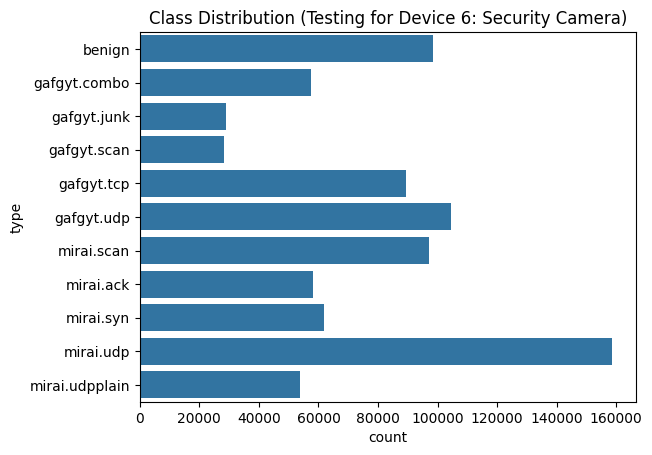

In [12]:
plt.title("Class Distribution (Testing for Device 6: Security Camera)")
sea.countplot(df["type"])

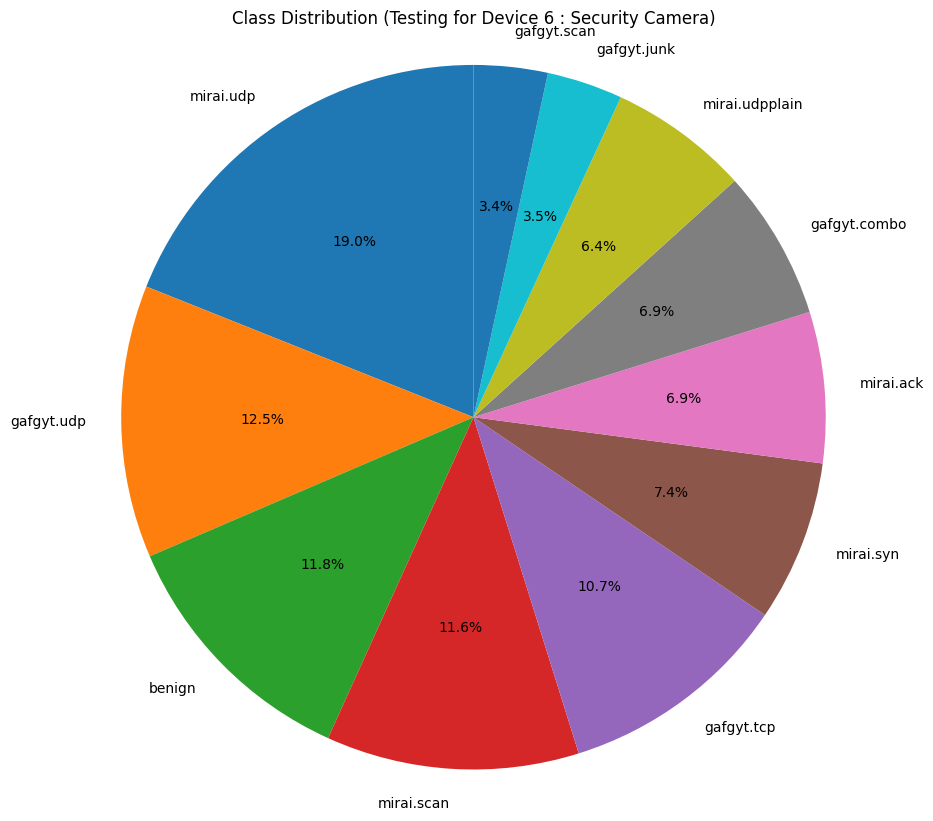

In [13]:
plt.figure(figsize=(10, 10))
plt.title("Class Distribution (Testing for Device 6 : Security Camera)")
df["type"].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.ylabel('')
plt.axis('equal')
plt.show()

#PCA (Principal Component Analysis)

Explained variance ratio (first 10): [0.31801151 0.20772713 0.12623303 0.07666951 0.06859201 0.03439817
 0.02626524 0.02402627 0.01647889 0.0156875 ]
Cumulative variance explained: 0.9999999999999999
PCA components kept: 115


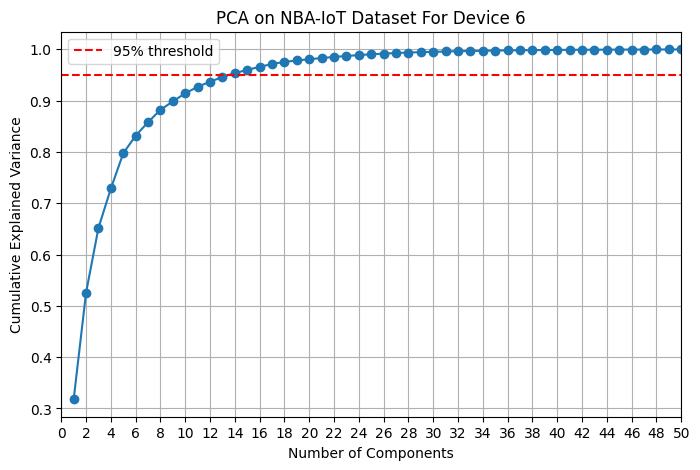

In [32]:
y = df['type']
x = df.drop(columns=['type'])

#Scale features
scaler = StandardScaler()
scaler.fit(x) # Fit only on numerical features
X = scaler.transform(x) # Transform only numerical features

pca = PCA(n_components=None, random_state=0)
X_pca = pca.fit_transform(X)

print("Explained variance ratio (first 10):", pca.explained_variance_ratio_[:10])
print("Cumulative variance explained:", pca.explained_variance_ratio_.sum())
print("PCA components kept:", X_pca.shape[1])

df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])], index=df.index)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance)+1),
         cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label="95% threshold")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA on NBA-IoT Dataset For Device 6")
plt.xticks(range(0, len(cumulative_variance)+1, 2))

plt.xlim([0, 50])
plt.grid()
plt.legend()
plt.show()

In [15]:
# Smallest k such that C(k) >= 95%
n_components = next(i for i, cv in enumerate(cumulative_variance, 1) if cv >= 0.95)
print("Optimal number of components (95% variance):", n_components)




Optimal number of components (95% variance): 14


In [16]:
pca_opt = PCA(n_components=n_components)
X_reduced = pca_opt.fit_transform(X)

print("Reduced shape:", X_reduced.shape)


Reduced shape: (836891, 14)


#t-SNE

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


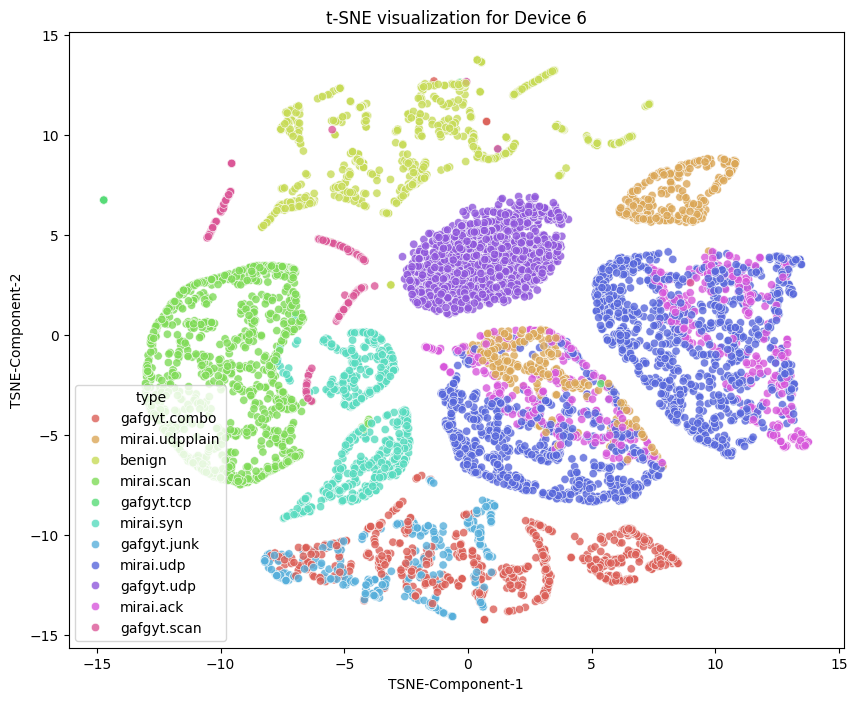

In [25]:
from sklearn.manifold import TSNE
import seaborn as sns

# Use the combined dataframe for device 6
# Assuming 'df' contains the data for device 6 as loaded previously
X_device = df.drop(columns=['type'])
y_device = df['type']

# Scale features for the single device data
scaler_device = StandardScaler()
X_scaled_device = scaler_device.fit_transform(X_device)

# Select a subset of the data for t-SNE
# Adjust the fraction or number of samples as needed based on computational resources
subset_size = 10000
if X_scaled_device.shape[0] > subset_size:
    np.random.seed(42) # for reproducibility
    subset_indices = np.random.choice(X_scaled_device.shape[0], subset_size, replace=False)
    X_subset = X_scaled_device[subset_indices]
    y_subset = y_device[subset_indices]
else:
    X_subset = X_scaled_device
    y_subset = y_device


# Perform t-SNE
# Adjust perplexity and n_iter based on your data and desired visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
X_tsne = tsne.fit_transform(X_subset)

# Create a DataFrame for plotting
tsne_df = pd.DataFrame(data=X_tsne, columns=['TSNE-Component-1', 'TSNE-Component-2'])
tsne_df['type'] = y_subset.reset_index(drop=True) # Ensure index aligns

# Visualize the t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="TSNE-Component-1", y="TSNE-Component-2",
    hue="type",
    palette=sns.color_palette("hls", len(y_subset.unique())),
    data=tsne_df,
    legend="full",
    alpha=0.8
)
plt.title('t-SNE visualization for Device 6')
plt.show()

In [30]:
from sklearn.manifold import TSNE
import plotly.express as px

# To be fixed

# Perform t-SNE with 3 components
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30, max_iter=300)
X_tsne_3d = tsne_3d.fit_transform(X_subset)

# Create a DataFrame for plotting
tsne_df_3d = pd.DataFrame(data=X_tsne_3d, columns=['TSNE-Component-1', 'TSNE-Component-2', 'TSNE-Component-3'])
tsne_df_3d['type'] = y_subset.reset_index(drop=True) # Ensure index aligns

# Visualize the t-SNE results in 3D using Plotly
fig = px.scatter_3d(tsne_df_3d, x='TSNE-Component-1', y='TSNE-Component-2', z='TSNE-Component-3',
                    color='type', title='3D t-SNE visualization for Device 6 (Subset)')
fig.show()

## Random Forest Model


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.3, random_state=42
)

# Random Forest
rf = RandomForestClassifier(max_depth=10, n_estimators=200, max_features='sqrt', random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluation
#Accuracy Metric
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
#F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)
#Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Accuracy: 0.9511367438303567
F1 Score: 0.9501772232163637

Classification Report:
                 precision    recall  f1-score   support

        benign       1.00      1.00      1.00     29455
  gafgyt.combo       0.89      0.97      0.93     17127
   gafgyt.junk       0.92      0.77      0.84      8741
   gafgyt.scan       1.00      1.00      1.00      8543
    gafgyt.tcp       1.00      1.00      1.00     26936
    gafgyt.udp       1.00      1.00      1.00     31368
     mirai.ack       0.91      0.73      0.81     17379
    mirai.scan       0.96      0.99      0.98     29191
     mirai.syn       0.99      0.94      0.96     18740
     mirai.udp       0.92      0.95      0.93     47485
mirai.udpplain       0.83      0.92      0.88     16103

      accuracy                           0.95    251068
     macro avg       0.95      0.93      0.94    251068
  weighted avg       0.95      0.95      0.95    251068



In [18]:
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Train F1:", f1_score(y_train, y_pred_train, average='weighted'))
print("Test F1:", f1_score(y_test, y_pred_test, average='weighted'))

Train Accuracy: 0.9530028694673989
Test Accuracy: 0.9511367438303567
Train F1: 0.9520684899841603
Test F1: 0.9501772232163637


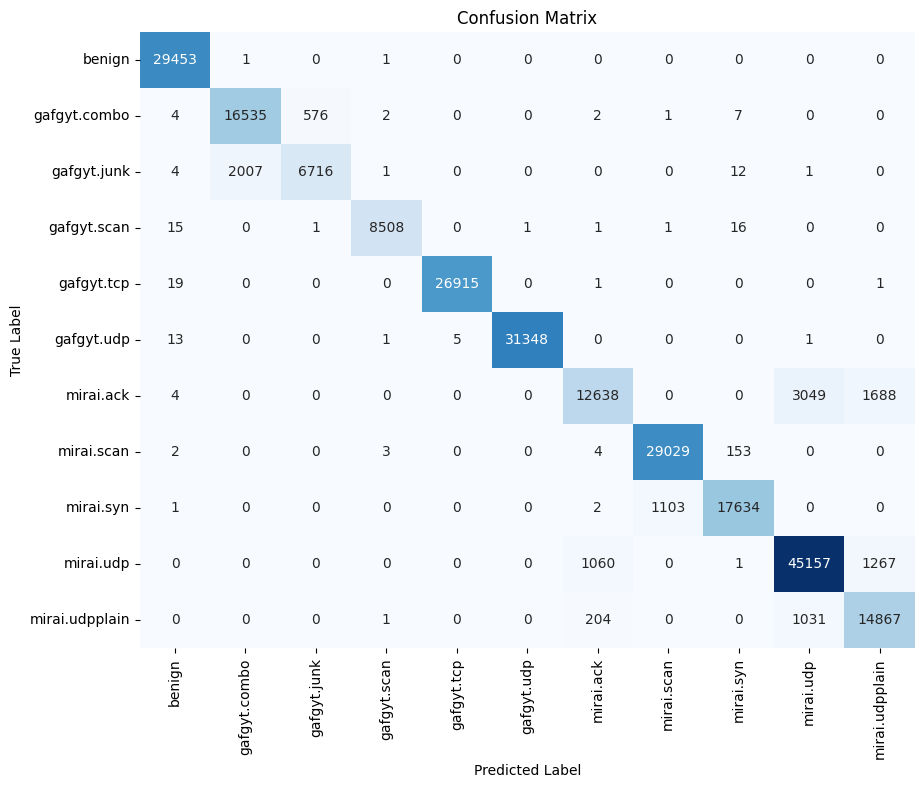

In [20]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Stratified Cross Validation (Random Forest)


In [21]:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score, average='weighted')
accuracy_scorer = make_scorer(accuracy_score)
# F1 Score
f1_scores = cross_val_score(rf, X, y, cv=skf, scoring=f1_scorer)
print("F1 Scores for each fold:", f1_scores)
print("Mean F1:", np.mean(f1_scores))
print("Std F1:", np.std(f1_scores))

# Accuracy
accuracy_scores = cross_val_score(rf, X, y, cv=skf, scoring=accuracy_scorer)
print("Accuracy for each fold:", accuracy_scores)
print("Mean Accuracy:", np.mean(accuracy_scores))
print("Std Accuracy:", np.std(accuracy_scores))


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_response.py", line 207, in _get_response_values
    raise ValueError(
ValueError: pos_label=1 is not a valid label: It should be one of ['benign' 'gafgyt.combo' 'gafgyt.junk' 'gafgyt.scan' 'gafgyt.tcp'
 'gafgyt.udp'

KeyboardInterrupt: 